# Ejemplo de predicción con Redes LSTM (Long Short-Term Memory)

Para este ejercicio se utilizarán datos del precio de la acción de Tesla disponibles en [Yahoo Finanzas - Tesla](https://finance.yahoo.com/quote/TSLA/history/?period1=1277818200&period2=1720249726). El periodo es del 29/06/2010 al 05/07/2024.

## Cargamos los paquetes necesarios

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

## Creamos una función de visualización

In [40]:
def visualizar(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Precio máximo real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.xlabel('Tiempo')
    plt.ylabel('Precio de la acción')
    plt.legend()
    plt.show()

## Cargamos el dataset

In [4]:
ruta = "https://raw.githubusercontent.com/vbatiz/intro-ML/main/notebooks/datasets/TSLA.csv"
df_stock = pd.read_csv(ruta, index_col='Date', parse_dates=['Date'])

In [5]:
df_stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [6]:
df_stock.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-06-28,199.550003,203.199997,195.259995,197.880005,197.880005,95438100
2024-07-01,201.020004,213.229996,200.850006,209.860001,209.860001,135691400
2024-07-02,218.889999,231.300003,218.059998,231.259995,231.259995,205047900
2024-07-03,234.559998,248.350006,234.250000,246.389999,246.389999,166561500
2024-07-05,249.809998,252.369995,242.460007,251.520004,251.520004,154170000


## Separamos el conjunto de datos en entrenamiento y validación

In [19]:
# Sets de entrenamiento y validación
# La LSTM se entrenará con datos de 2022 hacia atrás. La validación se hará con datos de 2023 en adelante.
# En ambos casos sólo se usará el valor más alto de la acción para cada día
# .iloc[:,1:2] nos permite seleccionar únicamente la columna High del dataset.
df_x_train = df_stock[:'2022'].iloc[:,1:2]
df_x_val = df_stock['2023':].iloc[:,1:2]

In [24]:
df_x_train.head()

,High
Date,
2010-06-29,1.666667
2010-06-30,2.028000
2010-07-01,1.728000
2010-07-02,1.540000
2010-07-06,1.333333


## Graficamos los datos

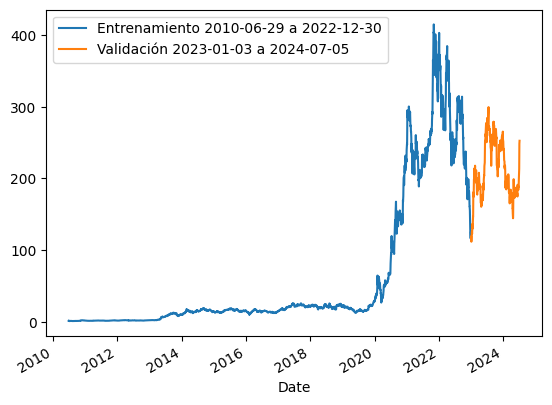

In [20]:
df_x_train['High'].plot(legend=True)
df_x_val['High'].plot(legend=True)
plt.legend([f'Entrenamiento {str(df_x_train.index[0])[:10]} a {str(df_x_train.index[-1])[:10]}', f'Validación {str(df_x_val.index[0])[:10]} a {str(df_x_val.index[-1])[:10]}'])
plt.show()

## Escalamos los datos

In [21]:
#Estandarización del conjunto de datos de entrenamiento (valores entre 0 y 1).
sc = MinMaxScaler(feature_range=(0,1))
df_x_train_scaled = sc.fit_transform(df_x_train)

In [23]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 60
X_train = []
Y_train = []
m = len(df_x_train_scaled)
print(m)

3150


## Generamos los lotes de entrenamiento

In [26]:
for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(df_x_train_scaled[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(df_x_train_scaled[i,0])

# convertimos los datos en arreglos de numpy
X_train, Y_train = np.array(X_train), np.array(Y_train)

## Preparamos los datos para poder introducirlos al modelo

In [27]:
# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Construimos el modelo

In [31]:
#Parámetros

dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50
print(dim_entrada)

(60, 1)


In [32]:
modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada)) #units = neuronas de la capa
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')

In [33]:
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Entrenamos el modelo

In [34]:
modelo.fit(X_train,Y_train,epochs=20,batch_size=32)

Epoch 1/20
97/97 [==============================] - 6s 39ms/step - loss: 0.0049
Epoch 2/20
97/97 [==============================] - 3s 27ms/step - loss: 8.9789e-04
Epoch 3/20
97/97 [==============================] - 2s 22ms/step - loss: 6.1707e-04
Epoch 4/20
97/97 [==============================] - 2s 23ms/step - loss: 5.5091e-04
Epoch 5/20
97/97 [==============================] - 2s 25ms/step - loss: 4.6375e-04
Epoch 6/20
97/97 [==============================] - 4s 42ms/step - loss: 3.9080e-04
Epoch 7/20
97/97 [==============================] - 2s 22ms/step - loss: 3.6181e-04
Epoch 8/20
97/97 [==============================] - 2s 23ms/step - loss: 3.4848e-04
Epoch 9/20
97/97 [==============================] - 2s 22ms/step - loss: 3.2160e-04
Epoch 10/20
97/97 [==============================] - 2s 23ms/step - loss: 3.0244e-04
Epoch 11/20
97/97 [==============================] - 4s 36ms/step - loss: 2.8356e-04
Epoch 12/20
97/97 [==============================] - 2s 22ms/step - loss: 2.78

## Realizamos ahora la predicción sobre el conjunto de validación

In [35]:
x_test = df_x_val.values
x_test = sc.transform(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


### Generamos los lotes y redimensionamos el conjunto de datos para su entrada al modelo

In [37]:
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

### Predecimos

In [38]:
predicciones = modelo.predict(X_test)
predicciones = sc.inverse_transform(predicciones)

10/10 [==============================] - 2s 17ms/step


## Graficamos los resultados

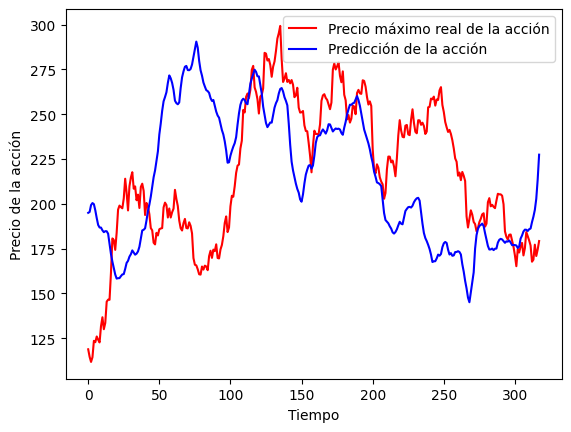

In [41]:
visualizar(df_x_val.values, predicciones)